In [1]:
import os
import io
from time import time
from datetime import datetime
import itertools
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #set to -1 to disable gpu (on fresh kernel)

In [2]:
import tensorflow as tf
import keras
import keras.backend as K

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()
# tf.test.is_gpu_available()

[]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [5]:
df = pd.read_csv(r"cleandf_40days_930_to_1830_lin_interpolated.csv")

In [6]:
df[:10]

,CAMERA_ID,TIMESTAMP,GEO_LON,GEO_LAT,DENSITY_VALUE
0,4,2010-10-11 09:30:00,-0.227278,51.491661,53547.356500
1,4,2010-10-11 10:00:00,-0.227278,51.491661,46199.700875
2,4,2010-10-11 10:30:00,-0.227278,51.491661,39602.705900
3,4,2010-10-11 11:00:00,-0.227278,51.491661,27179.430333
4,4,2010-10-11 11:30:00,-0.227278,51.491661,23527.222300
5,4,2010-10-11 12:00:00,-0.227278,51.491661,19940.461500
6,4,2010-10-11 12:30:00,-0.227278,51.491661,20405.220000
7,4,2010-10-11 13:00:00,-0.227278,51.491661,21775.247000
8,4,2010-10-11 13:30:00,-0.227278,51.491661,18727.309900
9,4,2010-10-11 14:00:00,-0.227278,51.491661,17784.156700


In [7]:
# df.DENSITY_VALUE = np.log(df.DENSITY_VALUE)
#print(df.DENSITY_VALUE)
#print(df.DENSITY_VALUE.min())
df.DENSITY_VALUE -= df.DENSITY_VALUE.min()
#print(df.DENSITY_VALUE.max())
df.DENSITY_VALUE /= df.DENSITY_VALUE.max() # scaling to [0,1]
df = df.pivot(index="TIMESTAMP",columns="CAMERA_ID",values="DENSITY_VALUE")
L = int(0.75 * len(df)) #3/4 of the length of data (over time) to be used as train and what ever comes after this would be for evaluation

In [8]:
df

CAMERA_ID,4,5,6,7,8,9,15,20,26,30,...,98,101,103,107,108,111,117,118,119,120
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2010-10-11 09:30:00,0.832721,0.736465,0.673375,0.875612,1.000000,0.722307,0.757152,0.680594,0.665648,0.684109,...,0.829776,0.784347,0.683784,0.690634,0.841041,0.767792,0.692569,0.767109,0.918728,0.862367
2010-10-11 10:00:00,0.717267,0.677046,0.539202,0.536337,0.928692,0.588867,0.552925,0.475241,0.500489,0.403454,...,0.758407,0.623102,0.457033,0.578736,0.778317,0.819475,0.549714,0.579417,0.716728,0.710952
2010-10-11 10:30:00,0.613608,0.580922,0.429255,0.479447,0.857383,0.536391,0.478475,0.367212,0.572155,0.488556,...,0.763662,0.777090,0.536671,0.652575,0.764758,0.828405,0.575197,0.616658,0.675727,0.736828
2010-10-11 11:00:00,0.418400,0.434257,0.266390,0.339875,0.725234,0.430256,0.267442,0.182961,0.365195,0.352724,...,0.622577,0.653502,0.499189,0.514473,0.577114,0.595619,0.433528,0.578645,0.592677,0.620731
2010-10-11 11:30:00,0.361012,0.404033,0.204576,0.306596,0.321575,0.389043,0.256184,0.179937,0.287719,0.352193,...,0.551073,0.404707,0.391159,0.448867,0.491578,0.472831,0.432047,0.497837,0.537321,0.566835
2010-10-11 12:00:00,0.304653,0.428367,0.183852,0.274417,0.289617,0.390220,0.238520,0.251622,0.230938,0.302200,...,0.400982,0.298795,0.360811,0.400292,0.475637,0.434021,0.443339,0.384552,0.416145,0.502617
2010-10-11 12:30:00,0.311956,0.304918,0.206830,0.266901,0.291421,0.414603,0.269281,0.253575,0.284814,0.249794,...,0.373132,0.264625,0.333265,0.376261,0.433424,0.433238,0.462217,0.432484,0.382512,0.483837
2010-10-11 13:00:00,0.333483,0.316085,0.242929,0.242035,0.285842,0.357791,0.320907,0.263375,0.325637,0.223476,...,0.487796,0.283220,0.318404,0.454659,0.450762,0.426478,0.391113,0.390846,0.378882,0.507946
2010-10-11 13:30:00,0.285591,0.366087,0.161221,0.244930,0.305829,0.303704,0.377544,0.264186,0.344778,0.177547,...,0.508135,0.304850,0.298616,0.483756,0.410347,0.475361,0.333088,0.451806,0.526446,0.457300


In [9]:
from keras import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers

from keras.layers import Input, Concatenate, Reshape, Lambda, Dropout
from keras.layers import TimeDistributed, Bidirectional
from keras.models import Model, load_model

from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger #added csv logger

In [10]:
TIMESTEPS = 19 * 7 #this should be played with to find a good one!
CAMERA_FEATURES = 58 #this is all the cameras we have. We focus on one at a time in this part of the study.
BATCH_SIZE = 1 #let's stick to STATEFUL RNN models with BATCH_SIZE of 1. We can try batch learning later but it kinda would be hard to implement the inference model (where it actually uses the model on incoming data to predict what happens next.)

In [11]:
#df must be pivoted df not the original one.
#TODO reimplement it for your understanding

def get_data_generator(df, camera_id, TIMESTEPS, mode):
    if mode == "train": 
        while True:
            for i in range(0, L-TIMESTEPS): #first 3/4th of the time (30 days)
                X = np.reshape(df.loc[:,camera_id].iloc[i:i+TIMESTEPS].values, newshape=(BATCH_SIZE,TIMESTEPS,1) ) # 1 is the number of features we have which is one cause for each camera we have have itself.
                y = np.reshape(df.loc[:,camera_id].iloc[i+TIMESTEPS], newshape=(BATCH_SIZE,1)) #it is just one number but we reshape it as two dim tensor (1,1)
                yield (X,y) #in generator must return a tuple of input and output in training mode.
                
    elif mode == "eval": 
        while True:
            for i in range(L-TIMESTEPS, len(df) - TIMESTEPS): #remaining quarter of data (10 days)
                X = np.reshape(df.loc[:,camera_id].iloc[i:i+TIMESTEPS].values, newshape=(BATCH_SIZE,TIMESTEPS,1) ) # 1 is the number of features we have which is one cause for each camera we have have itself.
                y = np.reshape(df.loc[:,camera_id].iloc[i+TIMESTEPS], newshape=(BATCH_SIZE,1))
                yield (X,y) #in generator must return a tuple of input and output in training mode.
                
    elif mode == "predict": 
        while True:
            for i in range(L-TIMESTEPS, len(df) - TIMESTEPS): #same as eval without target y
                yield np.reshape(df.loc[:,camera_id].iloc[i:i+TIMESTEPS].values, newshape=(BATCH_SIZE,TIMESTEPS,1) )

In [12]:
#you can use my code here from the all cameras model I'm working on. 
#function returns layer objects you need to add to your model where you need an LSTM block.
#It supports stacking up to 3 lstms and bidirectional lstm wrapper.
#assuming the model = Sequential()
#layers = get_lstm_layers(params)
#for layer in layers:
#    model.add(layer)
def get_lstm_layers(params):
    """returns keras tensor output of a block of stateful lstms (potentially stacked)."""
    n = params["stack_lstm_count"]

    layers = []
    
    lstm1 = LSTM( params["lstm1_units"],
                     #bii = (1,399,174)
                     batch_input_shape=(1,params["timesteps"],1),
                     #batch_input_shape=(1,params["timesteps"],params["dense_units"]), 
                     stateful=True,
                     return_sequences= True if n > 1 else False,
                     dropout=params["lstm1_dropout"],
                     recurrent_dropout=params["lstm1_recurrent_dropout"],
                     activity_regularizer=regularizers.l2(l=params["lstm1_l2reg"]),
                )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm1 = Bidirectional(lstm1, batch_input_shape=(1,params["timesteps"],1))#params["dense_units"])) #default mode is concat

    layers.append(lstm1)
                 
    if n == 1:
        return layers
        
    lstm2 = LSTM(params["lstm2_units"],
                     stateful=True,
                     return_sequences = True if n > 2 else False,
                     dropout=params["lstm2_dropout"],
                     recurrent_dropout=params["lstm2_recurrent_dropout"],
                     activity_regularizer=regularizers.l2(l=params["lstm2_l2reg"]),
                    )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm2 = Bidirectional(lstm2, batch_input_shape=(1,params["timesteps"],params["dense_units"])) #default mode is concat  
    
    layers.append(lstm2)
                 
    if n == 2:
        return layers
                
    
    lstm3 = LSTM(params["lstm3_units"],
                stateful=True,
                return_sequences=False,
                dropout=params["lstm3_dropout"],
                recurrent_dropout=params["lstm3_recurrent_dropout"],
                activity_regularizer=regularizers.l2(l=params["lstm3_l2reg"]),
               )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm3 = Bidirectional(lstm3,batch_input_shape=(1,params["timesteps"],params["dense_units"])) #default mode is concat  
                 
    layers.append(lstm3)
                 
    return layers

In [13]:
#I have been using Mean Exp Sq Error instead of Mean Sq Error (I am experimenting with both)
#Hoping exp would put more pressure on the model to capture spikes.

#You may need to change this 
#K is keras.backend

#Not sure if you need K.mean as it is only one value you predict not all cameras at once.
def exp_loss(yTrue,yPred):
    return K.mean(K.exp(K.square(yTrue - yPred,)))

In [14]:

paramss = []
paramss.append({"desc" : "testing_bidirectional", "timesteps" : 19*21, "loss" : "mse",
                "stack_lstm_count" : 2, "bidirectional_lstms" : False,
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0.6, "lstm2_recurrent_dropout" : 0, "lstm2_l2reg" : 0.05,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "LeakyReLU", 
                "alpha": 0.1})

paramss.append({"desc" : "mimic_v1_stacked_after_refactor", "timesteps" : 19*21, "loss" : "mse",
                "stack_lstm_count" : 2, 
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0.6, "lstm2_recurrent_dropout" : 0, "lstm2_l2reg" : 0.05,
                "dense_units" : 58*3, "dense_dropout" : 0.6, "dense_l2reg" : 0.001, "dense_activation" : "LeakyReLU",
               })

paramss.append({"desc" : "mimic_v1_stacked_with_mse_loss", "timesteps" : 19*21, "loss" : "mse",
                "stack_lstm_count" : 2, 
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0.4, "lstm2_recurrent_dropout" : 0, "lstm2_l2reg" : 0.05,
                "dense_units" : 58*3, "dense_dropout" : 0.6, "dense_l2reg" : 0.001, "dense_activation" : "LeakyReLU",
                "alpha": 0.1})

In [15]:
def get_model(params):
    #TODO: implement you model here. and return the model object.
    # you should start with a simple model that uses a relatively small LSTM to predict.
    model = Sequential()
    #lyrs = []
    lyrs = get_lstm_layers(params)
    
    for layr in lyrs:
        #print(layr.input_spec)
        #(batch_size, timesteps, units)
        model.add(layr)
    
    #
        
    
    model.add(Dense(1))#, activation = params["dense_activation"]))
    
    if(params["dense_activation"] == "LeakyReLU"):
        model.add(LeakyReLU(alpha= params["alpha"]))
        
    else:
        model.add(Activation(params["dense_activation"]))
    
    return model

In [16]:
camlist = [4, 5, 6, 7, 8, 9, 15, 20, 26, 30, 32, 34, 37, 39, 40, 42, 44, 45, 46, 47, 48, 49, 52, 53, 54, 56, 57, 58, 61, 62, 64, 70, 73, 75, 78, 79, 80, 81, 83, 84, 86, 87, 88, 91, 93, 95, 96, 97, 98, 101, 103, 107, 108, 111, 117, 118, 119, 120]

In [17]:
# current_time = lambda: int(round(time()*1000))

# print(str(current_time()))

# nsets = len(paramss)

# print(nsets)


# #print(CURRENT_TIME)

# losslist = []

# msqlist = []

# msqfname = "msq_per_cam.csv"

# lossfname = "loss_per cam.csv"

# total_loss = 0.0

# total_msq = 0.0

# # numpy.savetxt(msqfname, a, delimiter="\n")

# # numpy.savetext(lossfname, a, delimiter = '\n')

# for camid in camlist:

#     for params in paramss: 
#         #this way you can manually/automatically define your hyperparams to run and then let it run all the configs
#         #there are other ways for hyperparam tuning but I wrote it this way from scratch for my stuff and it seems to do its job.
#         #we might need a final hyper param tuning were it does a grid search of some of the parameters or a smart state space search (hopefully implemented already in a tool like Microsoft NNI)

#         model = get_model(params)

#         model.compile(optimizer=Adam(lr=0.001,clipnorm=1.), loss=params["loss"], metrics=["mse"])



#         print(model.summary())

#         #fname = str(i)+'.png'
#         #plot_model(model, to_file= fname, show_shapes = True, show_layer_names = True)

#         # If you are going to use tensorboard for visualization you need to pass a TensorBoard callback to the fit function.
#         # The default one, plots train and evaluation losses separately.
#         # I used this one:
#         # https://urldefense.proofpoint.com/v2/url?u=https-3A__stackoverflow.com_questions_47877475_keras-2Dtensorboard-2Dplot-2Dtrain-2Dand-2Dvalidation-2Dscalars-2Din-2Da-2Dsame-2Dfigure&d=DwIGaQ&c=sJ6xIWYx-zLMB3EPkvcnVg&r=_syK-BFuRYpXO3xxhpNENA&m=VESWBdIR2JRGr_zyNJ4AgZiGwnPzAt-BfFiuOgvF-40&s=yheitMrc8ziNbiYRUAUL5z1ArglNu5xYtwXCkPKF8O0&e=
#         # so that it would plot them in the same figure.

#         # LOGDIR = "logs/{}[{}]".format(params["desc"], CURRENT_TIME )     
#         # tensorboard = TrainValTensorBoard(log_dir= LOGDIR)

#         # One more thing about tensorboard callback: write_grads seems broken and not fixed yet. It would have been nice to see the gradients..
#         # write_grads=True, histogram_freq= 2, batch_size=1 )

#         #Earlystopping would stop training if the model validation (evaluation) loss does not improve over 
#         #patience epochs for at least min_delta.
#         es = EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0009, restore_best_weights=True)

#         bmodelname = str(camid)+"_"+str(current_time())+".hdf5"

#         print(bmodelname)

#         bmodelpath = "D:/Code/bestmodel/"+bmodelname

#         print(bmodelpath)

#         mc = ModelCheckpoint(bmodelpath, monitor = 'val_mean_squared_error', verbose = 1, save_best_only= True, 
#                             save_weights_only=False, mode='auto', period=1)

#     #     #logging parameters to text file
#         with open('params_log_lstm_per_camera_for_london.txt', 'a') as f:
#             print(params, file=f)

#         train_gen = get_data_generator(df, camid, params["timesteps"], mode = "train")
#     #     #don't reuse generator as it might be messed up.

#         #print(train_gen)

#         val_gen = get_data_generator(df, camid, params["timesteps"], mode="eval")

#         #csv_logger = CSVLogger(lname, append=True, separator=';')

#         #fname.write(str(params))

#         history = model.fit_generator(train_gen,
#                                        epochs = 250,
#                                        steps_per_epoch= L-TIMESTEPS,
#                                        validation_data = val_gen,
#                                        validation_steps = len(df) - L, 
#                                        callbacks=[es, mc]#, csv_logger] #tensorboard goes here
#                                       )

#         bestmod = load_model(bmodelpath)

#         test_gen = get_data_generator(df, camid, params["timesteps"], mode = "predict")

#         eval = bestmod.evaluate_generator(val_gen, steps = 174)
        
#         total_loss = total_loss+eval[0]
#         total_msq = total_msq+eval[1]
        
#         losslist.append(eval[0])
#         msqlist.append(eval[1])
#         print(eval)
#         #print(h.history.keys())


# #         npa = np.array(history.history['val_loss'])
# #         print("avg val loss: "+ str(np.mean(npa)))

# #        fname.write(str(np.mean(npa)))

#         #plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         #plt.plot(history.history['mean_squared_error'])
#         plt.plot(history.history['val_mean_squared_error'])
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'val'], loc = 'upper right')
#         plt.show()    

#         del model 
#         del history
#         K.clear_session() #to hopefully prevent slow down after a few models have run..


# #calculate mean of loss and mean of msq
# meanlosscam = total_loss/(len(losslist))
# meanmsqcam = total_msq/len(msqlist)

# losslist.append(meanlosscam)#final entry in each csv file would be the final av.loss/av.error
# msqlist.append(meanmsqcam)

# #convert to numpy array so as to later convert to csv
# np.asarray(losslist)
# np.asarray(msqlist)

# np.savetxt(lossfname, losslist)
# np.savetxt(msqfname, msqlist)

1565291597012
[[]]
[[]]
cam_num4
Index: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (1, 399, 80)              26240     
_________________________________________________________________
lstm_8 (LSTM)                (1, 80)                   51520     
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    81        
_________________________________________________________________
activation_4 (Activation)    (1, 1)                    0         
Total params: 77,841
Trainable params: 77,841
Non-trainable params: 0
_________________________________________________________________
None
4_1565291597551.hdf5
D:/4_1565291597551.hdf5
Epoch 1/250
437/437 [==============================] - 118s 270ms/step - loss: 0.0223 - mean_squared_error: 0.0170 - val_loss: 0.0270 - val_mean_squared_error: 0.0241

Epoch 0000

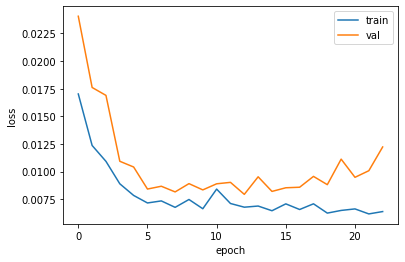

In [21]:
#CURRENT_TIME = str(datetime.now().time())

current_time = lambda: int(round(time()*1000))

print(str(current_time()))

camlist = [4]#, 5]#, 6, 7]#, 8, 9, 15, 20, 26, 30, 32, 34, 37, 39, 40, 42, 44, 45, 46, 47, 48, 49, 52, 53, 54, 56, 57, 58, 61, 62, 64, 70, 73, 75, 78, 79, 80, 81, 83, 84, 86, 87, 88, 91, 93, 95, 96, 97, 98, 101, 103, 107, 108, 111, 117, 118, 119, 120]

#print(CURRENT_TIME)

num_par_sets = len(paramss)

#list of lists per parameter set
setlosslist = []
setmsqlist = []

for i in range(0,num_par_sets):
    setlosslist.append([])
    setmsqlist.append([])
    
print(setlosslist)
print(setmsqlist)

msqfname = "msq_per_cam.csv"

lossfname = "loss_per cam.csv"

# numpy.savetxt(msqfname, a, delimiter="\n")

# numpy.savetext(lossfname, a, delimiter = '\n')

#setlosslist = [[4thcam_loss, 5thcamloss, 6thcamloss...],[4thcamloss, 5thcamloss, 6thcamloss],[4thcamloss, 5thcamloss, 6thcamloss]]

for camid in camlist:
    
    print("cam_num"+ str(camid))
    
    index = 0
    
    for params in paramss: 
        
        print("Index: "+str(index))
        #this way you can manually/automatically define your hyperparams to run and then let it run all the configs
        #there are other ways for hyperparam tuning but I wrote it this way from scratch for my stuff and it seems to do its job.
        #we might need a final hyper param tuning were it does a grid search of some of the parameters or a smart state space search (hopefully implemented already in a tool like Microsoft NNI)

        model = get_model(params)

        model.compile(optimizer=Adam(lr=0.001,clipnorm=1.), loss=params["loss"], metrics=["mse"])



        print(model.summary())

        #fname = str(i)+'.png'
        #plot_model(model, to_file= fname, show_shapes = True, show_layer_names = True)

        # If you are going to use tensorboard for visualization you need to pass a TensorBoard callback to the fit function.
        # The default one, plots train and evaluation losses separately.
        # I used this one:
        # https://urldefense.proofpoint.com/v2/url?u=https-3A__stackoverflow.com_questions_47877475_keras-2Dtensorboard-2Dplot-2Dtrain-2Dand-2Dvalidation-2Dscalars-2Din-2Da-2Dsame-2Dfigure&d=DwIGaQ&c=sJ6xIWYx-zLMB3EPkvcnVg&r=_syK-BFuRYpXO3xxhpNENA&m=VESWBdIR2JRGr_zyNJ4AgZiGwnPzAt-BfFiuOgvF-40&s=yheitMrc8ziNbiYRUAUL5z1ArglNu5xYtwXCkPKF8O0&e=
        # so that it would plot them in the same figure.

        # LOGDIR = "logs/{}[{}]".format(params["desc"], CURRENT_TIME )     
        # tensorboard = TrainValTensorBoard(log_dir= LOGDIR)

        # One more thing about tensorboard callback: write_grads seems broken and not fixed yet. It would have been nice to see the gradients..
        # write_grads=True, histogram_freq= 2, batch_size=1 )

        #Earlystopping would stop training if the model validation (evaluation) loss does not improve over 
        #patience epochs for at least min_delta.
        es = EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0009, restore_best_weights=True)

        bmodelname = str(camid)+"_"+str(current_time())+".hdf5"

        print(bmodelname)

        bmodelpath = "D:/"+bmodelname

        print(bmodelpath)

        mc = ModelCheckpoint(bmodelpath, monitor = 'val_mean_squared_error', verbose = 1, save_best_only= True, 
                            save_weights_only=False, mode='auto', period=1)

    #     #logging parameters to text file
        with open('params_log_lstm_per_camera_for_london.txt', 'a') as f:
            print(params, file=f)

        train_gen = get_data_generator(df, camid, params["timesteps"], mode = "train")
    #     #don't reuse generator as it might be messed up.

        #print(train_gen)

        val_gen = get_data_generator(df, camid, params["timesteps"], mode="eval")

        #csv_logger = CSVLogger(lname, append=True, separator=';')

        #fname.write(str(params))

        history = model.fit_generator(train_gen,
                                       epochs = 250,
                                       steps_per_epoch= L-TIMESTEPS,
                                       validation_data = val_gen,
                                       validation_steps = len(df) - L, 
                                       callbacks=[es, mc]#, csv_logger] #tensorboard goes here
                                      )

        bestmod = load_model(bmodelpath)

        test_gen = get_data_generator(df, camid, params["timesteps"], mode = "predict")

        eval = bestmod.evaluate_generator(val_gen, steps = 174)
        print(eval)
        
        setlosslist[index].append(eval[0])
        print(setlosslist[index])
        setmsqlist[index].append(eval[1])
        print(setmsqlist[index])
        
        index = index+1
        
        
        #print(h.history.keys())
        #plt.plot(history.history['loss'])
        #plt.plot(history.history['val_loss'])
        plt.plot(history.history['mean_squared_error'])
        plt.plot(history.history['val_mean_squared_error'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc = 'upper right')
        plt.show()    

        del model 
        del history
        K.clear_session() #to hopefully prevent slow down after a few models have run..
    


#for each parameter, 58 entries which are losses/errors for 58 different cameras. 
#Find the parameter set with least mean of errors
#write out that parameter set's error list to a csv

In [ ]:

print(setmsqlist)
print(len(setmsqlist[0]))
listofmeanmsq = []

for i in range(0, num_par_sets):
    currlist = setmsqlist[i]
    meanmsq = sum(currlist)/len(camlist)
    listofmeanmsq.append(meanmsq)
    
print(listofmeanmsq)
minindex = np.argmin(listofmeanmsq)

print(minindex)

finlist = setmsqlist[minindex]

np.asarray(finlist)
np.savetext(msqfname, finlist)

### Notes